In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
# from scipy.misc import imresize
from skimage.transform import resize as imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

# **Data Exploration**

Let's check
- The amount of data we have for each class
- Whether the data is balanced or not


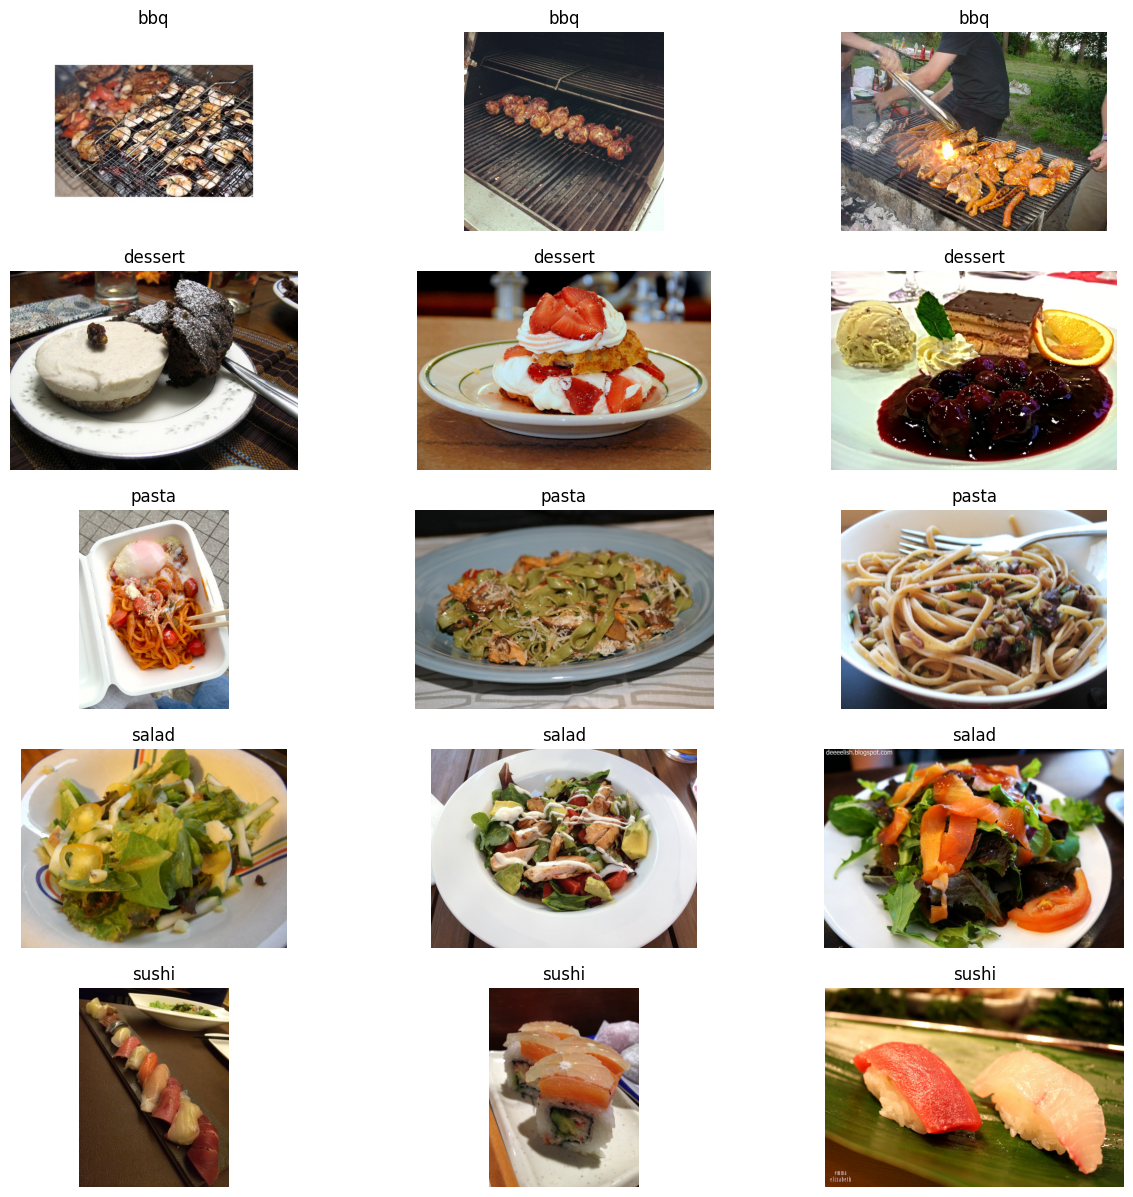

In [9]:
# randomly select 3 images from each category and show in grid
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
for i, category in enumerate(categories):
    category_path = os.path.join('data', category)
    images = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    for j in range(3):
        img_path = os.path.join(category_path, images[j])
        img = plt.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title(category)
        ax[i, j].axis('off')
plt.show()


In [5]:
# categories folders 'bbq' 'dessert' 'pasta' 'salad' 'sushi'
categories = ['bbq', 'dessert', 'pasta', 'salad', 'sushi']
num_images = defaultdict(int)
for category in categories:
    category_path = os.path.join('data', category)  # Replace 'path/to/your/folder' with the actual path to the category folder
    num_images[category] = len([f for f in listdir(category_path) if isfile(join(category_path, f))])
    print(category, num_images[category])


bbq 287
dessert 285
pasta 296
salad 293
sushi 282


Looks like the data is perfectly balanced.
BUT....

The number of images you have for each category is quite small for training a Convolutional Neural Network (CNN) from scratch. CNNs typically require large amounts of data to learn effectively without overfitting. Datasets used for training CNNs often contain thousands, if not tens of thousands, of images per category.


# Dealing with Small Datasets in Convolutional Neural Networks

When working with Convolutional Neural Networks (CNNs), having a large dataset is often beneficial as it allows the model to learn more effectively without overfitting. However, in situations where the dataset is small, there are several techniques that can be employed to work around this limitation:

## Data Augmentation

Data augmentation involves creating new training samples by applying random transformations to the existing images. These transformations can include rotation, scaling, shifting, flipping, and more. The main advantage of data augmentation is that it can significantly increase the size of the dataset and reduce the risk of overfitting by providing more varied data for the model to learn from.

## Transfer Learning

Transfer learning is another effective technique for dealing with small datasets. This involves using a model that has been pre-trained on a large dataset, such as ImageNet, and fine-tuning it on the specific task at hand. The underlying idea is that the pre-trained model has already learned useful features from the large dataset that can be leveraged for the task, even though the available dataset is small.

## Early Stopping

Early stopping is a form of regularization used to prevent overfitting when training a learner with an iterative method, such as gradient descent. This technique involves stopping the training process if the model's performance on a validation set stops improving for a certain number of iterations. This helps to ensure that the model does not overfit the training data by preventing it from learning too much from the noise in the data.


We are going to use all given techniques to train our model.

---

## Splitting the data 
Since the dataset is small, we will use a 80-10-10 split for the training, validation, and test sets, respectively.
- Training set: 80%
- Validation set: 10%
- Test set: 10%

In [19]:
# make train, validation and test splits for each category
for category in categories:
    category_path = os.path.join('data', category)
    train_path = os.path.join('data', 'train', category)
    valid_path = os.path.join('data', 'valid', category)
    test_path = os.path.join('data', 'test', category)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(valid_path):
        os.makedirs(valid_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    image_files = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=24)  # 30% for validation and testing
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=24)  # Split the 30% equally into validation and testing
    for file in train_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(train_path, file))
    for file in valid_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(valid_path, file))
    for file in test_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(test_path, file))
    print(category, len(train_files), len(valid_files), len(test_files))

bbq 229 29 29
dessert 228 28 29
pasta 236 30 30
salad 234 29 30
sushi 225 28 29


Most frequent size of the images

In [20]:
# Initialize a dictionary to store image sizes and their frequencies
size_freq = {}

for category in categories:
    category_path = os.path.join('data', category)
    image_files = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    for file in image_files:
        image_path = os.path.join(category_path, file)
        image = img.imread(image_path)
        # Get the size of the image
        size = image.shape[:2]  # We only consider the width and height, not the channels
        # Update the frequency of this size
        if size in size_freq:
            size_freq[size] += 1
        else:
            size_freq[size] = 1

# Find the size with the highest frequency
most_common_size = max(size_freq, key=size_freq.get)
print('Most common size:', most_common_size)

Most common size: (768, 1024)


---
# Data Augmentation

# For train and validation data

In [21]:

# Create a data generator for the training set
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Set range for random shear
    zoom_range=[.8, 1],  # Set range for random zoom
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Set strategy for filling in newly created pixels
)

# Create a data generator for the validation set
test_datagen = ImageDataGenerator()  # Only rescaling for validation set

# Create an iterator for the training set
train_generator = train_datagen.flow_from_directory(
    'data/train',  # Source directory for the training images
    target_size=(200, 200),  # All images will be resized to 200x200
    batch_size=32,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

# Create an iterator for the validation set
valid_generator = test_datagen.flow_from_directory(
    'data/valid',  # Source directory for the validation images
    target_size=(200, 200),  # All images will be resized to 200x200
    batch_size=32,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

# Create an iterator for the test set
test_generator = test_datagen.flow_from_directory(
    'data/test',  # Source directory for the test images
    target_size=(200, 200),  # All images will be resized to 200x200
    batch_size=32,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

Found 1378 images belonging to 5 classes.


Found 643 images belonging to 5 classes.
Found 460 images belonging to 5 classes.


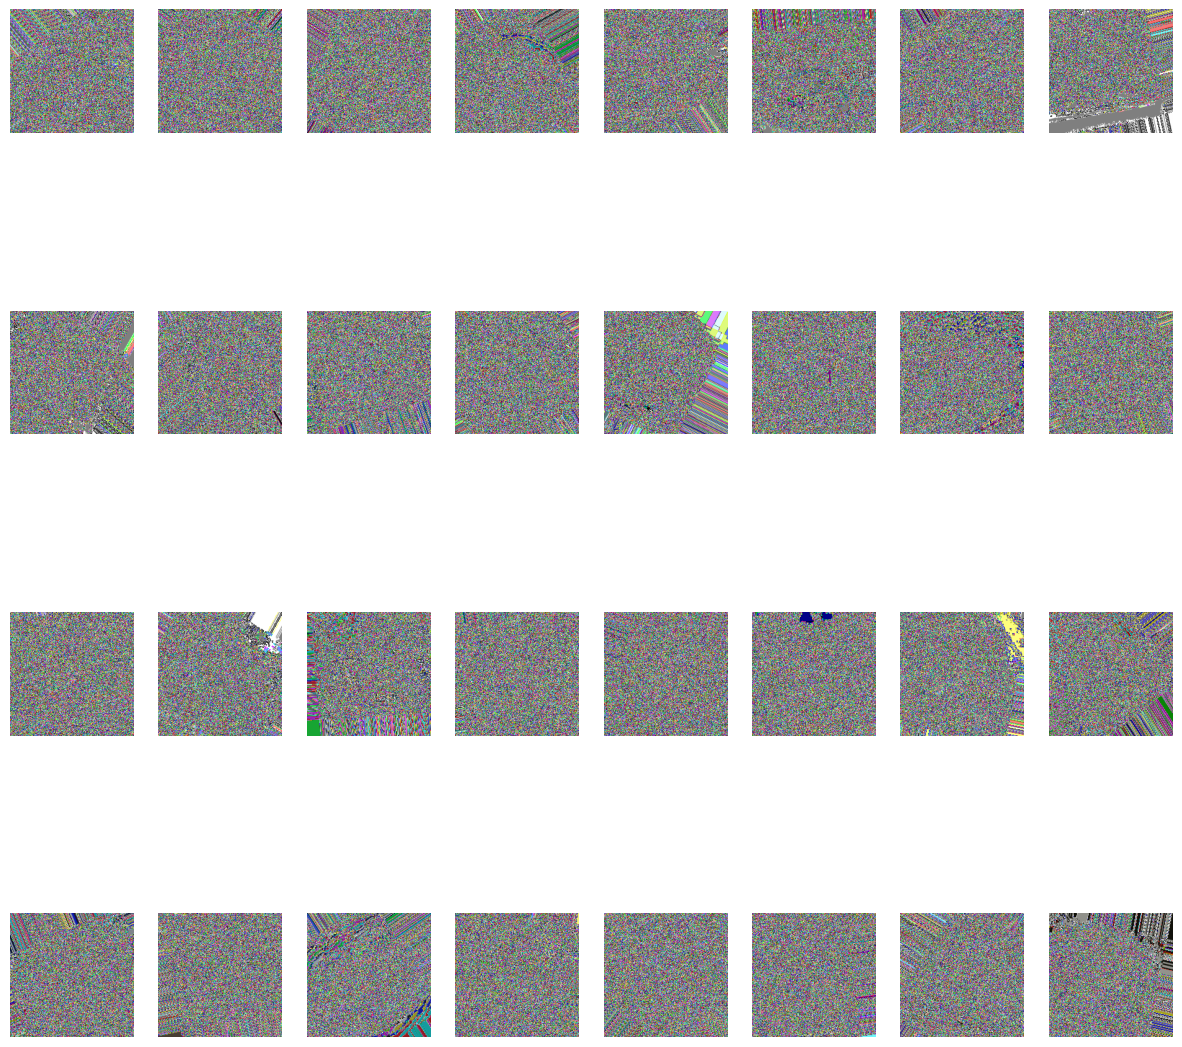

In [23]:
def reverse_preprocess_input(x0):
    x = x0 / 2.0
    x += 0.5
    x *= 255.
    return x
# view the generated images
x, y = train_generator.next()
fig, ax = plt.subplots(4, 8, figsize=(15, 15))
for i in range(32):
    ax[i // 8, i % 8].imshow(reverse_preprocess_input(x[i]).astype(np.uint8))
    ax[i // 8, i % 8].axis('off')
plt.show()
